# Heat pipe modeling

Author: Riccardo Boccelli (STEN PoliMi)

This notebook is about the implementation of a dynamic lumped model for heat pipes.

Note1: the notebook is intended to be runned as a whole since some code sections overwrites some variables. 
Note2: the notebook comes with a heat_pipe_model.py file which is a shorter version of this notebook. The file allows to make the same calculation of this notebook. However, some steps have been neglected since they consists just in a repetition of the code but with small variations (simulation time, number of timesteps ...).


## Description of the PhD

My PhD research is about nuclear energy systems for space applications: The modeling of the reactor and the other component's dynamics is an essential task for evaluating the performance and safety of the energy system. 

Modern nuclear reactor concepts uses heat pipes (HP) as cooling technology. Therefore, part of my job is to find/develop appropriate models for the dynamics of HP.

Once the model is proven to work with simple input/output heat, it may be coupled with more complex codes which simulates other system's components.

## Goals and approach

The main goal of this notebook is to develop and test a numerical model for the heat pipes found in literature. I need to validate it with experimental data, compare different solvers and plot the results.


The reference paper is:

"C. Ferrandi, F. Iorizzo, M. Mameli, S. Zinna, M. Marengo, Lumped parameter model of sintered heat pipe: Transient numerical analysis and validation"

The authors describes the model with an equivalent electrical circuit (see the figures below).



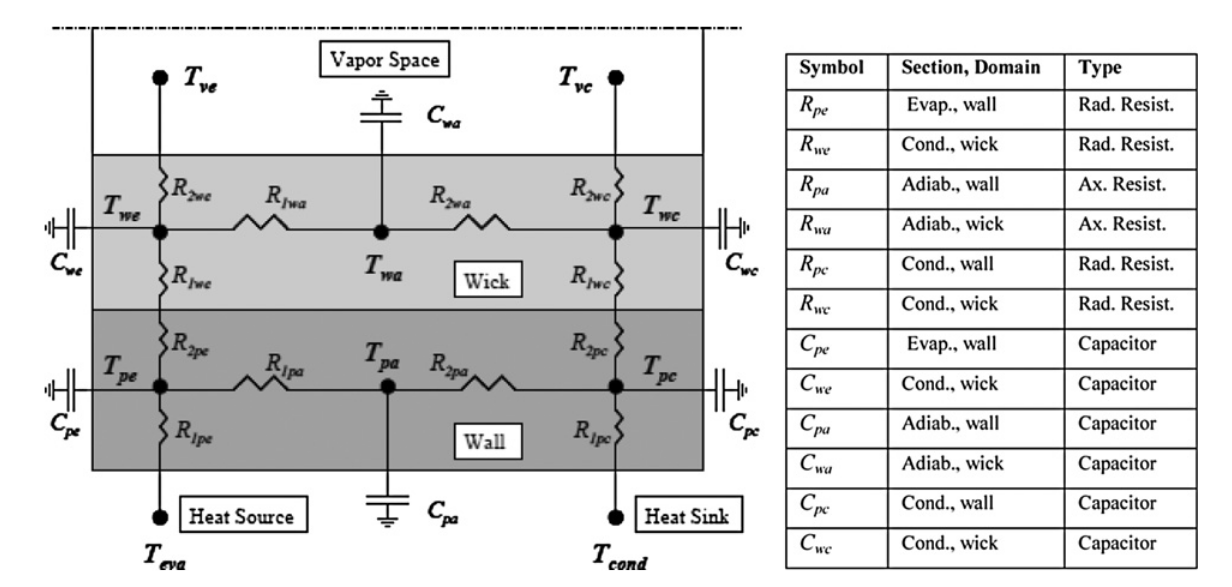

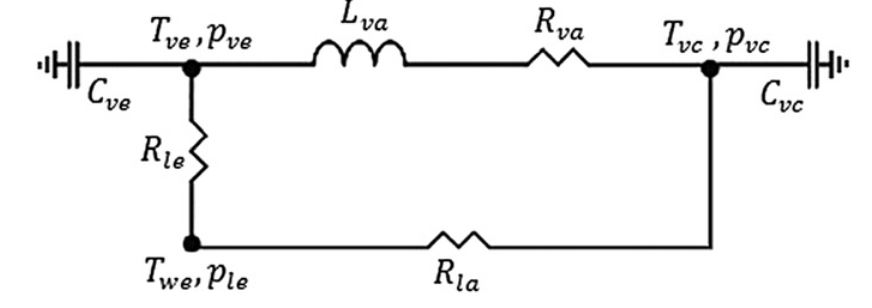

This circuit corresponds to the following system of equations:

\begin{cases} 
C_{pe}\frac{dT_{pe}}{dt} & = & Q_{in} - \frac{T_{pe} - T_{pa}}{R_{1pa}} - \frac{T_{pe} - T_{we}}{R_{2pe} + R_{1we}} \\ 
C_{pc}\frac{dT_{pc}}{dt} & = & \frac{T_{pa} - T_{pc}}{R_{2pa}} - \frac{T_{wc} - T_{pc}}{R_{2pc} + R_{1wc}} - \frac{T_{pc} - T_f}{R_{1pc} + R_f} \\ 
C_{we}\frac{dT_{we}}{dt} & = & \frac{T_{pe} - T_{we}}{R_{2pe} + R_{1we}} - \frac{T_{we} - T_{wa}}{R_{1wa}} -  \frac{T_{we} - T_{ve}}{R_{2wa}} \\
C_{wc}\frac{dT_{wc}}{dt} & = & - \frac{T_{wc} - T_{pc}}{R_{2pc} + R_{1wc}} - \frac{T_{wa} - T_{wc}}{R_{2wa}} + \frac{T_{vc} - T_{wc}}{R_{2wc}} \\
C_{pa}\frac{dT_{pa}}{dt} & = & - \frac{T_{pe} - T_{pa}}{R_{1pa}} - \frac{T_{pa} - T_{pc}}{R_{2pa}} \\
C_{wa}\frac{dT_{wa}}{dt} & = & \frac{T_{we} - T_{wa}}{R_{1wa}} - \frac{T_{wa} - T_{wc}}{R_{2wa}} \\
L_{va}\frac{d \dot m_v}{dt} & = & R_{va}\dot m_v + P_{ve} - P_{vc} \\ 
C_{ve}\frac{dP_{ve}}{dt} & = & \frac{T_{we} - T_{ve}}{R_{2we}h_{lv}} -\dot m_v \\
C_{vc}\frac{dP_{vc}}{dt} & = & \dot m_v - \frac{T_{vc} - T_{wc}}{R_{2wc}h_{lv}} \\
\frac{dT_{ve}}{dt} & = & \frac{\gamma - 1}{\gamma} \frac{T_{ve}}{P_{ve}}\frac{dP_{ve}}{dt}\\
\frac{dT_{vc}}{dt} & = & \frac{\gamma - 1}{\gamma} \frac{T_{vc}}{P_{vc}}\frac{dP_{vc}}{dt}\\
\frac{dM_{le}}{dt} & = &  \frac{P_{vc} - P_{ve}}{R_{la}} +  f \frac{2\sigma}{R_{la}r_c} - \frac{T_{we}-T_{ve}}{R_{2we}h_{lve}}\\
\frac{dM_{lc}}{dt} & = &  -\frac{P_{vc} - P_{ve}}{R_{la}} -  f \frac{2\sigma}{R_{la}r_c} - \frac{T_{wc}-T_{vc}}{R_{2wc}h_{lve}}
\end{cases} 

### Symbols

p: pipe

w: wick

v: vapor

l: liquid

e: evaporator region

a: adiabatic region

c: condenser region


T: temperature

P: pressure

R: thermal resistance

C: heat capacity 

L: fluidic inductance

M: mass

$\dot m$: mass flow rate

$\gamma$: politropic index

$\sigma$: surface tension

f: correction coefficient

### Approach

1) Read the thermophysical properties of the fluid, the heat pipe geometry file, the "parameters" file (initial condition, heat input/output)
2) Fitting data point as function of temperature
3) Create the initial conditions and the power input function $\dot Q(t)$
5) Solve the system dynamic
6) Plot the results

### Required tools

Pandas for reading .xlsx files 

Numpy for arrays

scipy for data interpolation

scipy for ode integration

matplotlib for visualisation

## Step 1. Import data with pandas

Import pandas and read ".xlsx" files conaining fluid thermophysical properties, heat pipe parameters, initial conditions and inputs.

In [218]:
import pandas as pd

### Thermophysical data

In [219]:
filename_fluid = "water.xlsx" #Change here the fluid

thermophys_data = pd.ExcelFile(filename_fluid)
print(type(thermophys_data))

thermophys_data = thermophys_data.parse("Sheet1") #overwrite to get a DataFrame
print(type(thermophys_data))

thermophys_data

<class 'pandas.io.excel._base.ExcelFile'>
<class 'pandas.core.frame.DataFrame'>


,Temperature (K),Saturation pressure (Pa),Latent heat (kJ/kg),Liquid density (kg/m3),Vapor density (kg/m3),Liquid viscosity (N-s/m2),Vapor viscosity (N-s/m2),Liquid thermal conductivity (W/m-K),Vapor thermal conductivity (W/m-K),Liquid surface tension (N/m),Liquid specific heat (kJ/kg-K),Vapor specific heat (kJ/kg-K)
0,308.00,2336.8,2453.8,999.00,0.01729,0.001002,0.000009,0.602,0.0188,0.07288,4.182,1.874
1,313.15,7374.9,2406.5,993.05,0.05110,0.000651,0.000010,0.630,0.0201,0.06948,4.179,1.894
2,333.15,19919.0,2358.4,983.28,0.13020,0.000463,0.000010,0.653,0.0216,0.06607,4.185,1.924
3,353.15,47359.0,2308.9,971.82,0.29320,0.000351,0.000011,0.669,0.0231,0.06269,4.197,1.969
4,373.15,101325.0,2251.2,958.77,0.59740,0.000279,0.000012,0.680,0.0248,0.05891,4.216,2.034
5,393.15,198540.0,2202.9,943.39,1.12100,0.000230,0.000013,0.685,0.0267,0.05496,4.245,2.124
6,413.15,361360.0,2144.9,925.93,1.96560,0.000195,0.000013,0.687,0.0288,0.05079,4.285,2.245
7,433.15,618040.0,2082.2,907.44,3.25890,0.000169,0.000014,0.684,0.0313,0.04651,4.339,2.406
8,453.15,1002700.0,2014.0,887.31,5.15970,0.000149,0.000015,0.676,0.0341,0.04219,4.408,2.615
9,473.15,1555100.0,1939.0,865.05,7.86530,0.000134,0.000016,0.664,0.0375,0.03777,4.497,2.883


### Heat pipe geometry specification

In [220]:
filename_hp = "heat_pipe_specs.xlsx" #heat pipe data specification

hp_data = pd.ExcelFile(filename_hp)
print(type(hp_data))

hp_data = hp_data.parse("Sheet1") #overwrite to get a DataFrame
print(type(hp_data))

hp_data

<class 'pandas.io.excel._base.ExcelFile'>
<class 'pandas.core.frame.DataFrame'>


,evaporator length (m),adiabatic length (m),condenser length (m),pipe external diameter (m),pipe internal diameter (m),wick internal diameter (m),wick permeability,wick porosity,wick effective porosity,cavity radius (m),wick heat capacity (J/kg-K),wick thermal conductivity (W/m-K),wick density (kg/m3),pipe heat capacity (J/kg-K),pipe thermal conductivity (W/m-K),pipe density (kg/m3)
0,0.6,0.09,0.2,0.0191,0.0188,0.0173,1.500000e-09,0.9,0.5,0.000022,380,390,8920,380,390,8920


### Input/output power and initial temperature

In [221]:
filename_par = "parameters.xlsx" #thermal parameters specification

parameters_data = pd.ExcelFile(filename_par)
print(type(hp_data))

parameters_data = parameters_data.parse("Sheet1") #overwrite to get a DataFrame
print(type(parameters_data))

parameters_data

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,input power (W),htc (W/m2-K),cooling fluid temperature (K),initial temperature
0,443,1350,294,296


## Step 2. Fit of fluid thermophysical properties

Initially, the code was supposed to use temperature dependent thermophysical properties. However, some errors were encountered concerning the interpolation: "A value (88.46216301526994) in x_new is below the interpolation range's minimum value (208.0)". This error appears especially with "Radau" solver.

A first attempt was to add two artificial temperatures to enlarge the interpolation region, however, this did not solve the problem completely since changing some heat pipe parameters the problem still exists. Therefore, I decided to use the interpolation just for the initial value of the thermophysical properties, and then are kept constant for the simulation. This approach is coherent with what has been done in the reference paper. 

The default interpolation method is linear but it is possible to change it by editing the "interpolation_method" variable

In [222]:
import numpy as np
from numpy.polynomial import Polynomial #not used
from scipy import interpolate


interpolation_method = "linear"


#extract data from DataFrame to arrays

temperature_for_fit = thermophys_data["Temperature (K)"] #get the dataframe slice
temperature_for_fit = temperature_for_fit.values #get only the values
temperature_for_fit = temperature_for_fit.tolist() #convert to list
temperature_for_fit = np.array([temperature_for_fit[0]-100] +  temperature_for_fit + [temperature_for_fit[-1]+100]) #extend and convert to an array


#poly_deg = 4 #degree of the polynomial


#Fit all the required parameters

#pressure_for_fit = thermophys_data["Saturation pressure (Pa)"].values
#p_sat = Polynomial.fit(temperature_for_fit, pressure_for_fit,poly_deg) #note that np.polyfit is now legacy
p_sat_for_fit = thermophys_data["Saturation pressure (Pa)"].values
p_sat_for_fit = p_sat_for_fit.tolist() #convert in list
p_sat_for_fit = np.array([p_sat_for_fit[0]] + p_sat_for_fit + [p_sat_for_fit[-1]]) #duplicate first and last elements

p_sat = interpolate.interp1d(temperature_for_fit, p_sat_for_fit,kind = interpolation_method) 


latentheat_for_fit = thermophys_data["Latent heat (kJ/kg)"].values
latentheat_for_fit = latentheat_for_fit.tolist() #convert in list
latentheat_for_fit = np.array([latentheat_for_fit[0]] + latentheat_for_fit + [latentheat_for_fit[-1]])*1e3 #duplicate first and last elements


#hlv_sat = Polynomial.fit(temperature_for_fit, latentheat_for_fit,poly_deg) 
hlv_sat = interpolate.interp1d(temperature_for_fit, latentheat_for_fit,kind = interpolation_method) 

liquiddensity_for_fit = thermophys_data["Liquid density (kg/m3)"].values.tolist()
liquiddensity_for_fit = np.array([liquiddensity_for_fit[0]] + liquiddensity_for_fit + [liquiddensity_for_fit[-1]])
#rhol_sat = Polynomial.fit(temperature_for_fit, liquiddensity_for_fit,poly_deg) 
rhol_sat =  interpolate.interp1d(temperature_for_fit, liquiddensity_for_fit,kind = interpolation_method) 

vapordensity_for_fit = thermophys_data["Vapor density (kg/m3)"].values.tolist()
vapordensity_for_fit = np.array([vapordensity_for_fit[0]] + vapordensity_for_fit + [vapordensity_for_fit[-1]])
#rhov_sat = Polynomial.fit(temperature_for_fit, vapordensity_for_fit,poly_deg) 
rhov_sat = interpolate.interp1d(temperature_for_fit, vapordensity_for_fit,kind= interpolation_method) 

liquidviscosity_for_fit = thermophys_data["Liquid viscosity (N-s/m2)"].values.tolist()
liquidviscosity_for_fit = np.array([liquidviscosity_for_fit[0]] + liquidviscosity_for_fit + [liquidviscosity_for_fit[-1]])
#mul_sat = Polynomial.fit(temperature_for_fit, liquidviscosity_for_fit,poly_deg) 
mul_sat = interpolate.interp1d(temperature_for_fit, liquidviscosity_for_fit,kind = interpolation_method) 

vaporviscosity_for_fit = thermophys_data["Vapor viscosity (N-s/m2)"].values.tolist()
vaporviscosity_for_fit = np.array([vaporviscosity_for_fit[0]] + vaporviscosity_for_fit + [vaporviscosity_for_fit[-1]])
#muv_sat = Polynomial.fit(temperature_for_fit, vaporviscosity_for_fit,poly_deg) 
muv_sat = interpolate.interp1d(temperature_for_fit, vaporviscosity_for_fit,kind=interpolation_method) 

liquidconductivity_for_fit = thermophys_data["Liquid thermal conductivity (W/m-K)"].values.tolist()
liquidconductivity_for_fit = np.array([liquidconductivity_for_fit[0]] + liquidconductivity_for_fit + [liquidconductivity_for_fit[-1]])
#kl_sat = Polynomial.fit(temperature_for_fit, liquidconductivity_for_fit,poly_deg) 
kl_sat = interpolate.interp1d(temperature_for_fit, liquidconductivity_for_fit,kind=interpolation_method)

liquidtension_for_fit = thermophys_data["Liquid surface tension (N/m)"].values.tolist()
liquidtension_for_fit = np.array([liquidtension_for_fit[0]] + liquidtension_for_fit + [liquidtension_for_fit[-1]])
#sigma_sat = Polynomial.fit(temperature_for_fit, liquidtension_for_fit,poly_deg) 
sigma_sat = interpolate.interp1d(temperature_for_fit, liquidtension_for_fit,kind = interpolation_method)

liquidcapacity_for_fit = (thermophys_data["Liquid specific heat (kJ/kg-K)"].values*1e3).tolist()
liquidcapacity_for_fit = np.array([liquidcapacity_for_fit[0]] + liquidcapacity_for_fit + [liquidcapacity_for_fit[-1]])
#cl_sat = Polynomial.fit(temperature_for_fit, liquidcapacity_for_fit,poly_deg) 
cl_sat = interpolate.interp1d(temperature_for_fit, liquidcapacity_for_fit,kind = interpolation_method) 


temperature_for_plot = np.linspace(temperature_for_fit[0],temperature_for_fit[-1], 1000)


### Polt the interpolation function to see the correctness

Here I check I have not made any mistakes by plotting the thermophysical data and their interpolation.

To have a nicer plot I used the subplots function, I specified the figure size and I selected the "sharex" option. The same has been done for all the other plots.

In [223]:
%matplotlib inline

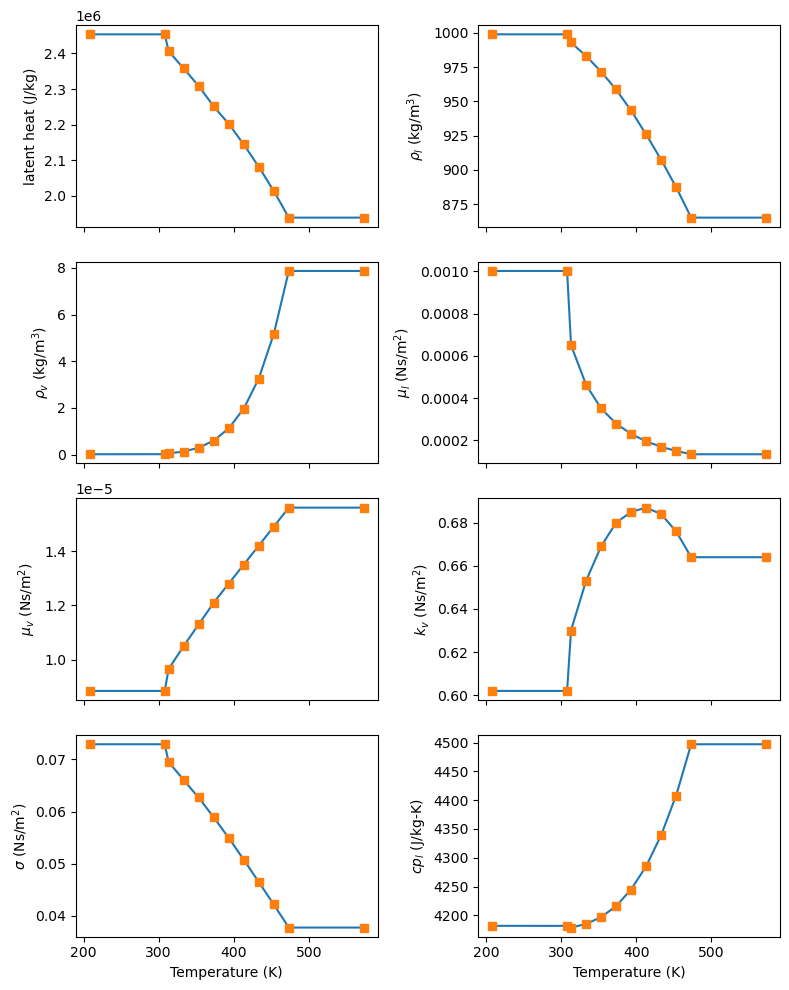

In [224]:
import matplotlib.pyplot as plt


#create subplots

fig, axs = plt.subplots(4,2,sharex=True, figsize = (8,10))


axs[0,0].plot(temperature_for_plot,hlv_sat(temperature_for_plot))
axs[0,0].plot(temperature_for_fit,latentheat_for_fit, linestyle = "none", marker = "s")
axs[0,0].set_ylabel("latent heat (J/kg)")

axs[0,1].plot(temperature_for_plot,rhol_sat(temperature_for_plot))
axs[0,1].plot(temperature_for_fit,liquiddensity_for_fit, linestyle = "none", marker = "s")
axs[0,1].set_ylabel("$\u03C1_l$ (kg/m$^3$)")

axs[1,0].plot(temperature_for_plot,rhov_sat(temperature_for_plot))
axs[1,0].plot(temperature_for_fit,vapordensity_for_fit, linestyle = "none", marker = "s")
axs[1,0].set_ylabel("$\u03C1_v$ (kg/m$^3$)")

axs[1,1].plot(temperature_for_plot,mul_sat(temperature_for_plot))
axs[1,1].plot(temperature_for_fit,liquidviscosity_for_fit, linestyle = "none", marker = "s")
axs[1,1].set_ylabel("$\mu_l$ (Ns/m$^2$)")

axs[2,0].plot(temperature_for_plot,muv_sat(temperature_for_plot))
axs[2,0].plot(temperature_for_fit,vaporviscosity_for_fit, linestyle = "none", marker = "s")
axs[2,0].set_ylabel("$\mu_v$ (Ns/m$^2$)")

axs[2,1].plot(temperature_for_plot,kl_sat(temperature_for_plot))
axs[2,1].plot(temperature_for_fit,liquidconductivity_for_fit, linestyle = "none", marker = "s")
axs[2,1].set_ylabel("$k_v$ (Ns/m$^2$)")

axs[3,0].plot(temperature_for_plot,sigma_sat(temperature_for_plot))
axs[3,0].plot(temperature_for_fit,liquidtension_for_fit, linestyle = "none", marker = "s")
axs[3,0].set_ylabel("$\sigma$ (Ns/m$^2$)")
axs[3,0].set_xlabel("Temperature (K)")

axs[3,1].plot(temperature_for_plot,cl_sat(temperature_for_plot))
axs[3,1].plot(temperature_for_fit,liquidcapacity_for_fit, linestyle = "none", marker = "s")
axs[3,1].set_ylabel("$cp_l$ (J/kg-K)")
axs[3,1].set_xlabel("Temperature (K)")

axs[3,0].ticklabel_format(style="sci", axis = "y")
axs[3,1].ticklabel_format(style="sci", axis = "y")

axs[2,0].ticklabel_format(style="sci", axis = "y")
axs[2,1].ticklabel_format(style="sci", axis = "y")

axs[1,0].ticklabel_format(style="sci", axis = "y")
axs[1,1].ticklabel_format(style="sci", axis = "y")

axs[0,0].ticklabel_format(style="sci", axis = "y")
axs[0,1].ticklabel_format(style="sci", axis = "y")

fig.tight_layout() #adjust space between subplots, minimize overlap



### Create the required variables from the fila data

Note that .values attribute of a dataframe returns an array! but we need floats to avoid errors. see the example below:

In [225]:
hp_data["pipe density (kg/m3)"].values

array([8920])

Here we extract all the necessary information from the dataframes

In [226]:
R = 8.314/(18e-3) #perfect gas reduced constant
gamma = 1.33      #cp/cv


#SOLID PROPERTIES
rhop = float(hp_data["pipe density (kg/m3)"].values)             #kg/m3
kp = float(hp_data["pipe thermal conductivity (W/m-K)"].values)  #W/mK
cp = float(hp_data["pipe heat capacity (J/kg-K)"].values)        #J/kg/K

rhow0 = float(hp_data["wick density (kg/m3)"].values)                #kg/m3
kw0 = float(hp_data["wick thermal conductivity (W/m-K)"].values)     #kg/m3
cw0 = float(hp_data["wick heat capacity (J/kg-K)"].values)           #kg/m3

#HP SPECS
dep = float(hp_data["pipe external diameter (m)"].values)
dip = float(hp_data["pipe internal diameter (m)"].values)
diw = float(hp_data["wick internal diameter (m)"].values)

print("outer pipe diameter (m): ", dep)
print("inner pipe diameter (m): ", dip)
print("inner wick diameter (m): ", diw)


Leva = float(hp_data["evaporator length (m)"].values)
La = float(hp_data["adiabatic length (m)"].values)
Lcond = float(hp_data["condenser length (m)"].values)

epsilon = float(hp_data["wick porosity"].values)
epsilon_eff = float(hp_data["wick effective porosity"].values)     #kg/m3
rc = float(hp_data["cavity radius (m)"].values)
K = float(hp_data["wick permeability"].values)

#compute cooling area in condenser
Af = Lcond*2*np.pi*(dep/2)+np.pi*(dep/2)**2  #condenser outer surface (cooling)
hf = float(parameters_data["htc (W/m2-K)"].values)


#VOLUMES
Vc = Lcond*np.pi*(diw**2)/4
Ve = Leva*np.pi*(diw**2)/4

#effective length
Leff = Leva/6 + La + Lcond/6

#INPUT POWER
Qin0 =float(parameters_data["input power (W)"].values)

#COOLING PART
Tf = float(parameters_data["cooling fluid temperature (K)"].values)

outer pipe diameter (m):  0.0191
inner pipe diameter (m):  0.0188
inner wick diameter (m):  0.0173


### Build the initial condition vector

In this section I build the vector y0 containing the initial conditions:

In [227]:

T0 = float(parameters_data["initial temperature"].values)

#INITIAL CONDITIONS
Mle_0 = rhol_sat(T0)*epsilon*Leva*np.pi*(dip**2 - diw**2)/4 #liquid mass in evaporator
Mlc_0 = rhol_sat(T0)*epsilon*Lcond*np.pi*(dip**2 - diw**2)/4 #liquid mass in adiabatic region
pve0 = float(p_sat(T0))#T0*R*rhov_sat(T0)#0.023360e5 pressure in evaporator
pvc0 = float(p_sat(T0))#T0*R*rhov_sat(T0)#0.023360e5 pressure in condenser
#T0*R*rhova
y0 = [T0,T0,T0,T0,T0,T0,0,pve0,pvc0,T0,T0,Mle_0,0*Mlc_0]

#float conversion is required otherwise the list is a mix between scalars and arrays



### Build the input power function

Qin(t) contains an analytical formula for the power input, similar to what has been done in the reference paper

Text(0.5, 1.0, 'Input power transient')

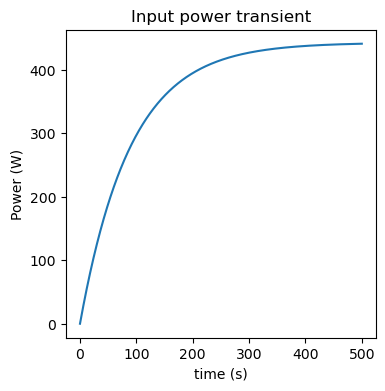

In [228]:
def Qin(t):
    return Qin0*(1-np.exp(-t/90))


#create a time vector for plot
tt = np.linspace(0,500,1000)

#create power vector for plot
Qin_plt = Qin(tt)

plt.figure(figsize = [4,4])
plt.plot(tt,Qin_plt)
plt.ylabel("Power (W)")
plt.xlabel("time (s)")
plt.title("Input power transient")

## Step 3. Creation of the numerical model

hp_model1(t,y) contains all the 13 dynamic equations

Creation of the heat pipe model. In this version, fluid properties are avaluated at the initial temperature only This to avoid errors from the code. 

hp_modelOLD(t,y) is the old version with temperature dependent parameters, it is not suggested to use it.

In [229]:
def hp_model1(t,y):
    
    #for more clarity in the equation i save y vector in variables with clearer name
    Tpe = y[0] #pipe evaporator temperature
    Tpc = y[1] #pipe condenser temperature
    Twe = y[2] #wick evaporator temperature
    Twc = y[3] #wick condenser temperature
    Tpa = y[4] #pipe adiabatic temperature
    Twa = y[5] #wick adiabatic temperature
    mdotv = y[6] #vapor mass flow rate
    Pve = y[7] #vapor pressure evaporator region
    Pvc = y[8] #vapor pressure condenser region
    Tve = y[9] #vapor evaporator temperature
    Tvc = y[10] #vapor condenser temperature
    Mle = y[11] #liquid mass in evaporator
    Mlc = y[12] #liquid mass in condenser
  
    
    #get liquid termal conductivity from temperature
    kle = kl_sat(T0)#kl_sat(Twe)
    klc = kle#kl_sat(Twc)
    kla = kle#kl_sat(Twa)
    
    
    #thermophysical prop in the three regions
    mule = mul_sat(T0)#mul_sat(Twe)
    mula = mule#mul_sat(Twa)
    muva = muv_sat(T0)#(muv_sat(Tve) + muv_sat(Tvc))/2
    
    rhole = rhol_sat(T0)#rhol_sat(Twe)
    rhola = rhole#rhol_sat(Twa)
    rholc = rhola#rhol_sat(Twc)
    rhova = rhov_sat(T0)#(rhov_sat(Tve) + rhov_sat(Tvc))/2
    
    
    #wrapped screen wick effective thermal conductivity
    kwe = kle*((kle+kw0) - (1-epsilon_eff)*(kle-kw0))/((kle+kw0)+(1-epsilon_eff)*(kle-kw0))
    kwc = klc*((klc+kw0) - (1-epsilon_eff)*(klc-kw0))/((klc+kw0)+(1-epsilon_eff)*(klc-kw0))
    kwa = klc*((kla+kw0) - (1-epsilon_eff)*(kla-kw0))/((kla+kw0)+(1-epsilon_eff)*(kla-kw0))
    
    #sintered wick effective thermal conductivity
    #kwe = kw0*(2 + (kle/kw0) -2*epsilon_eff*(1- kle/kw0))/(2 + (kle/kw0)+epsilon_eff*(1-(kle/kw0)))
    #kwc = kw0*(2 + (klc/kw0) -2*epsilon_eff*(1- klc/kw0))/(2 + (klc/kw0)+epsilon_eff*(1-(klc/kw0)))
    #kwa = kw0*(2 + (kla/kw0) -2*epsilon_eff*(1- kla/kw0))/(2 + (kla/kw0)+epsilon_eff*(1-(kla/kw0)))
    
    
    #THERMAL RESISTANCES
    
    #radial resistance 
    R1pe = np.log(dep/(dip+dep)*2)/(2*np.pi*kp*Leva) #(dip+dep)/2 average diameter
    R2pe = np.log((dip+dep)/2/dip)/(2*np.pi*kp*Leva)
    R1we = np.log(dip/(diw+dip)*2)/(2*np.pi*kwe*Leva)
    R2we = np.log((diw+dip)/2/diw)/(2*np.pi*kwe*Leva)
    R1pc = np.log(dep/(dip+dep)*2)/(2*np.pi*kp*Lcond)
    R2pc = np.log((diw+dip)/2/diw)/(2*np.pi*kp*Lcond)
    R1wc = np.log(dip/(diw+dip)*2)/(2*np.pi*kwc*Lcond)#np.log(dep/(dip+dep)*2)/(2*np.pi*kwc*Lcond)
    R2wc = np.log((diw+dip)/2/diw)/(2*np.pi*kwc*Lcond)#np.log((diw+dip)/2/diw)/(2*np.pi*kwc*Lcond)
   

    #R2wa = np.log((diw+dip)/2/diw)/(2*np.pi*kwa*La)
    #R2wa = np.log((diw+dip)/2/diw)/(2*np.pi*kp*La)
    Rf = 1/hf/Af #external cooling resistance

    #axial resistances
    #which is the length?
    R1pa = (Leva+La)/2/kp/(np.pi*(dep**2-dip**2)/4)
    R2pa = (La+Lcond)/2/kp/(np.pi*(dep**2-dip**2)/4)
    R1wa = (Leva+La)/2/kwa/(np.pi*(dip**2-diw**2)/4)
    R2wa = (La+Lcond)/2/kwa/(np.pi*(dip**2-diw**2)/4)
    
    
    
    
    #specific heat in evaporator, adiabatic region, condenser
    cle = cl_sat(T0)#cl_sat(Twe) 
    clc = cle#cl_sat(Twc) 
    cla = cle#cl_sat(Twa) 

    
    #Thermal capacities
    Cpe  = rhop*cp*(Leva*np.pi*(dep**2-dip**2)/4)
    Cwe  = ((rhow0*cw0)*(1-epsilon)+(rhole*cle)*epsilon)*(Leva*np.pi*(dip**2-diw**2)/4)
    Cpa  = rhop*cp*(La*np.pi*(dep**2-dip**2)/4)
    Cwa  = ((rhow0*cw0)*(1-epsilon)+(rhola*cla)*epsilon)*(La*np.pi*(dip**2-diw**2)/4)
    Cpc  = rhop*cp*(Lcond*np.pi*(dep**2-dip**2)/4)
    Cwc  = ((rhow0*cw0)*(1-epsilon)+(rholc*clc)*epsilon)*(Lcond*np.pi*(dip**2-diw**2)/4)

    

    
    #vapor inductance and resistances
    Lva  = Leff/(np.pi*(diw/2)**2)
    Rle  = mule*Leva/(K*rhole*epsilon*np.pi*(dip**2-diw**2)/4)
    Rla  = mula/(K*rhola*epsilon*np.pi*(dip**2-diw**2)/4)
    Rva  = 8*muva*Leff/(rhova*np.pi*(diw/2)**4) 
    
    
    #thermophysical prop in ev, ad, cond
    hlve = hlv_sat(T0)#hlv_sat(Twe)
    hlvc = hlve#hlv_sat(Twc)
    
    sigmaa = sigma_sat(T0)#sigma_sat(Twa)
    sigmae = sigmaa#sigma_sat(Twe)
    sigmac = sigmaa#sigma_sat(Twc)
    sigma = np.mean([sigmaa,sigmae,sigmac])
    
    #UPDATE VAPOR CAPACITIES
    Cvc  = Vc/gamma/R/Tvc
    Cve  = Ve/gamma/R/Tve
 
    Qout = (Tpc-Tf)/(R1pc+Rf)

    
    #if Tpe >290:
    #    Tpe = 290
    
    if (Mle <= Mle_0) and (Mle > 0): #Mle_0 should be the mass with full filled wick
        f = -(Mle/Mle_0)+1
        f_masse = 1
    elif Mle>Mle_0: 
        f = (Pve-Pvc)/(2*sigma/rc)
        f_masse = 1
    else: 
        f = 0
        f_masse = 0
    

    #differential equations
    dydt = [
        Qin(t)/Cpe - (Tpe - Tpa)/R1pa/Cpe - (Tpe-Twe)/(R2pe+R1we)/Cpe,
        -(Tpc-Tpa)/R2pa/Cpc - (Tpc-Twc)/(R2pc+R1wc)/Cpc - Qout/Cpc,
        -(Twe -Twa)/R2wa/Cwe + (Tpe-Twe)/(R2pe+R1we)/Cwe - (Twe-Tve)/R2we/Cwe,
        -(Twc-Twa)/R2wa/Cwc + (Tpc-Twc)/(R2pc+R1wc)/Cwc - (Twc-Tvc)/R2wc/Cwc,
        -(Tpa-Tpe)/R1pa/Cpa - (Tpa-Tpc)/R2pa/Cpa,
        -(Twa-Twe)/R1wa/Cwa - (Twa-Twc)/R2wa/Cwa,
        Rva/Lva*mdotv + Pve/Lva - Pvc/Lva,
        f_masse*(Twe-Tve)/Cve/R2we/hlve - mdotv/Cve,
        mdotv/Cvc + (Twc-Tvc)/R2wc/hlvc/Cvc,
        (gamma-1)/gamma*Tve/Pve*(f_masse*(Twe-Tve)/Cve/R2we/hlve - mdotv/Cve), #check fmasse
        (gamma-1)/gamma*Tvc/Pvc*(mdotv/Cvc + (Twc-Tvc)/R2wc/hlvc/Cvc),
        #+ 2*sigma*f/Rva/rc -f_masse*(Twe-Tve)/R2we/hlve, #check fmasse
        #+ (Pvc-Pve)/Rva + 2*sigma*f/Rva/rc -f_masse*(Twe-Tve)/R2we/hlve, #check fmasse
        + (Pvc-Pve)/Rla + 2*sigma*f/Rla/rc -f_masse*(Twe-Tve)/R2we/hlve, #check fmasse
        #- 2*sigma*f/Rva/rc -(Twc-Tvc)/R2wc/hlvc]
        #- (Pvc-Pve)/Rva - 2*sigma*f/Rva/rc -(Twc-Tvc)/R2wc/hlvc]
        - (Pvc-Pve)/Rla - 2*sigma*f/Rla/rc -(Twc-Tvc)/R2wc/hlvc]
        
  
    return dydt

    

#Old model with temperature dependent parameters
def hp_modelTdependent(t,y):
    
    #for more clarity in the equation i save y vector in variables with clearer name
    Tpe = y[0] #pipe evaporator temperature
    Tpc = y[1] #pipe condenser temperature
    Twe = y[2] #wick evaporator temperature
    Twc = y[3] #wick condenser temperature
    Tpa = y[4] #pipe adiabatic temperature
    Twa = y[5] #wick adiabatic temperature
    mdotv = y[6] #vapor mass flow rate
    Pve = y[7] #vapor pressure evaporator region
    Pvc = y[8] #vapor pressure condenser region
    Tve = y[9] #vapor evaporator temperature
    Tvc = y[10] #vapor condenser temperature
    Mle = y[11] #liquid mass in evaporator
    Mlc = y[12] #liquid mass in condenser
  
    
    #get liquid termal conductivity from temperature
    kle = kl_sat(Twe)
    klc = kl_sat(Twc)
    kla = kl_sat(Twa)
    
    
    #thermophysical prop in the three regions
    mule = mul_sat(Twe)
    mula = mul_sat(Twa)
    muva = (muv_sat(Tve) + muv_sat(Tvc))/2
    
    rhole = rhol_sat(Twe)
    rhola = rhol_sat(Twa)
    rholc = rhol_sat(Twc)
    rhova = (rhov_sat(Tve) + rhov_sat(Tvc))/2
    
    
    #wrapped screen wick effective thermal conductivity
    kwe = kle*((kle+kw0) - (1-epsilon_eff)*(kle-kw0))/((kle+kw0)+(1-epsilon_eff)*(kle-kw0))
    kwc = klc*((klc+kw0) - (1-epsilon_eff)*(klc-kw0))/((klc+kw0)+(1-epsilon_eff)*(klc-kw0))
    kwa = klc*((kla+kw0) - (1-epsilon_eff)*(kla-kw0))/((kla+kw0)+(1-epsilon_eff)*(kla-kw0))
    
    #sintered wick effective thermal conductivity
    #kwe = kw0*(2 + (kle/kw0) -2*epsilon_eff*(1- kle/kw0))/(2 + (kle/kw0)+epsilon_eff*(1-(kle/kw0)))
    #kwc = kw0*(2 + (klc/kw0) -2*epsilon_eff*(1- klc/kw0))/(2 + (klc/kw0)+epsilon_eff*(1-(klc/kw0)))
    #kwa = kw0*(2 + (kla/kw0) -2*epsilon_eff*(1- kla/kw0))/(2 + (kla/kw0)+epsilon_eff*(1-(kla/kw0)))
    
    
    #THERMAL RESISTANCES
    
    #radial resistance 
    R1pe = np.log(dep/(dip+dep)*2)/(2*np.pi*kp*Leva) #(dip+dep)/2 average diameter
    R2pe = np.log((dip+dep)/2/dip)/(2*np.pi*kp*Leva)
    R1we = np.log(dip/(diw+dip)*2)/(2*np.pi*kwe*Leva)
    R2we = np.log((diw+dip)/2/diw)/(2*np.pi*kwe*Leva)
    R1pc = np.log(dep/(dip+dep)*2)/(2*np.pi*kp*Lcond)
    R2pc = np.log((diw+dip)/2/diw)/(2*np.pi*kp*Lcond)
    R1wc = np.log(dip/(diw+dip)*2)/(2*np.pi*kwc*Lcond)#np.log(dep/(dip+dep)*2)/(2*np.pi*kwc*Lcond)
    R2wc = np.log((diw+dip)/2/diw)/(2*np.pi*kwc*Lcond)#np.log((diw+dip)/2/diw)/(2*np.pi*kwc*Lcond)
   

    #R2wa = np.log((diw+dip)/2/diw)/(2*np.pi*kwa*La)
    #R2wa = np.log((diw+dip)/2/diw)/(2*np.pi*kp*La)
    Rf = 1/hf/Af #external cooling resistance

    #axial resistances
    #which is the length?
    R1pa = (Leva+La)/2/kp/(np.pi*(dep**2-dip**2)/4)
    R2pa = (La+Lcond)/2/kp/(np.pi*(dep**2-dip**2)/4)
    R1wa = (Leva+La)/2/kwa/(np.pi*(dip**2-diw**2)/4)
    R2wa = (La+Lcond)/2/kwa/(np.pi*(dip**2-diw**2)/4)
    
    
    
    
    #specific heat in evaporator, adiabatic region, condenser
    cle = cl_sat(Twe) 
    clc = cl_sat(Twc) 
    cla = cl_sat(Twa) 

    
    #Thermal capacities
    Cpe  = rhop*cp*(Leva*np.pi*(dep**2-dip**2)/4)
    Cwe  = ((rhow0*cw0)*(1-epsilon)+(rhole*cle)*epsilon)*(Leva*np.pi*(dip**2-diw**2)/4)
    Cpa  = rhop*cp*(La*np.pi*(dep**2-dip**2)/4)
    Cwa  = ((rhow0*cw0)*(1-epsilon)+(rhola*cla)*epsilon)*(La*np.pi*(dip**2-diw**2)/4)
    Cpc  = rhop*cp*(Lcond*np.pi*(dep**2-dip**2)/4)
    Cwc  = ((rhow0*cw0)*(1-epsilon)+(rholc*clc)*epsilon)*(Lcond*np.pi*(dip**2-diw**2)/4)

    

    
    #vapor inductance and resistances
    Lva  = Leff/(np.pi*(diw/2)**2)
    Rle  = mule*Leva/(K*rhole*epsilon*np.pi*(dip**2-diw**2)/4)
    Rla  = mula/(K*rhola*epsilon*np.pi*(dip**2-diw**2)/4)
    Rva  = 8*muva*Leff/(rhova*np.pi*(diw/2)**4) 
    
    
    #thermophysical prop in ev, ad, cond
    hlve = hlv_sat(Twe)
    hlvc = hlv_sat(Twc)
    
    sigmaa = sigma_sat(Twa)
    sigmae = sigma_sat(Twe)
    sigmac = sigma_sat(Twc)
    sigma = np.mean([sigmaa,sigmae,sigmac])
    
    #UPDATE VAPOR CAPACITIES
    Cvc  = Vc/gamma/R/Tvc
    Cve  = Ve/gamma/R/Tve


    
    Qout = (Tpc-Tf)/(R1pc+Rf)

    
    #if Tpe >290:
    #    Tpe = 290
    
    if (Mle <= Mle_0) and (Mle > 0): #Mle_0 should be the mass with full filled wick
        f = -(Mle/Mle_0)+1
        f_masse = 1
    elif Mle>Mle_0: 
        f = (Pve-Pvc)/(2*sigma/rc)
        f_masse = 1
    else: 
        f = 0
        f_masse = 0
    
    
    
    

    #differential equations
    dydt = [
        Qin(t)/Cpe - (Tpe - Tpa)/R1pa/Cpe - (Tpe-Twe)/(R2pe+R1we)/Cpe,
        -(Tpc-Tpa)/R2pa/Cpc - (Tpc-Twc)/(R2pc+R1wc)/Cpc - Qout/Cpc,
        -(Twe -Twa)/R2wa/Cwe + (Tpe-Twe)/(R2pe+R1we)/Cwe - (Twe-Tve)/R2we/Cwe,
        -(Twc-Twa)/R2wa/Cwc + (Tpc-Twc)/(R2pc+R1wc)/Cwc - (Twc-Tvc)/R2wc/Cwc,
        -(Tpa-Tpe)/R1pa/Cpa - (Tpa-Tpc)/R2pa/Cpa,
        -(Twa-Twe)/R1wa/Cwa - (Twa-Twc)/R2wa/Cwa,
        Rva/Lva*mdotv + Pve/Lva - Pvc/Lva,
        f_masse*(Twe-Tve)/Cve/R2we/hlve - mdotv/Cve,
        mdotv/Cvc + (Twc-Tvc)/R2wc/hlvc/Cvc,
        (gamma-1)/gamma*Tve/Pve*(f_masse*(Twe-Tve)/Cve/R2we/hlve - mdotv/Cve), #check fmasse
        (gamma-1)/gamma*Tvc/Pvc*(mdotv/Cvc + (Twc-Tvc)/R2wc/hlvc/Cvc),
        #+ 2*sigma*f/Rva/rc -f_masse*(Twe-Tve)/R2we/hlve, #check fmasse
        #+ (Pvc-Pve)/Rva + 2*sigma*f/Rva/rc -f_masse*(Twe-Tve)/R2we/hlve, #check fmasse
        + (Pvc-Pve)/Rla + 2*sigma*f/Rla/rc -f_masse*(Twe-Tve)/R2we/hlve, #check fmasse
        #- 2*sigma*f/Rva/rc -(Twc-Tvc)/R2wc/hlvc]
        #- (Pvc-Pve)/Rva - 2*sigma*f/Rva/rc -(Twc-Tvc)/R2wc/hlvc]
        - (Pvc-Pve)/Rla - 2*sigma*f/Rla/rc -(Twc-Tvc)/R2wc/hlvc]
        
        
    
    return dydt



## Step 4. Solve the model with different solvers

Python allows for different solvers: 
1) RK23:Explicit Runge-Kutta method of order 3(2)
2) RK45:Explicit Runge-Kutta method of order 5(4)
3) DOP853:Explicit Runge-Kutta method of order 8
4) Radau: Implicit Runge-Kutta method of the Radau IIA family of order 5
5) BDF: Implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation
6) LSODA: Adams/BDF method with automatic stiffness detection and switching

Implicit solvers (Radau, BDF, LSODA) will be compared in terms of results and computational time, to do that, time package is required.

In [230]:
from scipy.integrate import solve_ivp
import time #required to measure the simulation time


#TIME SPAN
tt = [0,600]

#SOLVE THE MODEL - Radau
st = time.time() #measure the starting time

solution = solve_ivp(hp_model1,t_span = tt, y0 = y0 ,method='Radau')
et = time.time() #measure the final time

print("simulation time Radau (s):", round(et-st,4)) #print the simulation duration in seconds

#SAVE THE SOLUTION - Radau
t_rad = solution.t
y_rad = solution.y



#SOLVE THE MODEL - BDF

st = time.time()
solution = solve_ivp(hp_model1,t_span = tt, y0 = y0 ,method='BDF')
et = time.time()

print("simulation time BDF (s):", round(et-st,4))

#SAVE THE SOLUTION - BDF
t_bdf = solution.t
y_bdf = solution.y

#SOLVE THE MODEL - LSODA

st = time.time()
solution = solve_ivp(hp_model1,t_span = tt, y0 = y0 ,method='LSODA')
et = time.time()

print("simulation time LSODA (s):", round(et-st,4))

#SAVE THE SOLUTION - LSODA
t_lsoda = solution.t
y_lsoda = solution.y

#Note: explicit RK method are not adopted since are pretty slow for this model, stiff problem


simulation time Radau (s): 0.0324
simulation time BDF (s): 0.0246
simulation time LSODA (s): 0.052


It seems that BDF is the faster solver for this problem, followed by Radau and LSODA in third position

## Step 5. Plot the results and compare the solvers

Here I compare the solution of the two approaches, also with experimental data

### Temperatures plot

Definition of experimental data:

In [231]:
#reference values
elgenk_times = [0,66,130,225,600]
elgenk_wallTempe = np.array([296,316,330,338,342])
elgenk_wallTempc = np.array([296,306,315,319,322])

Creation of the subplots:

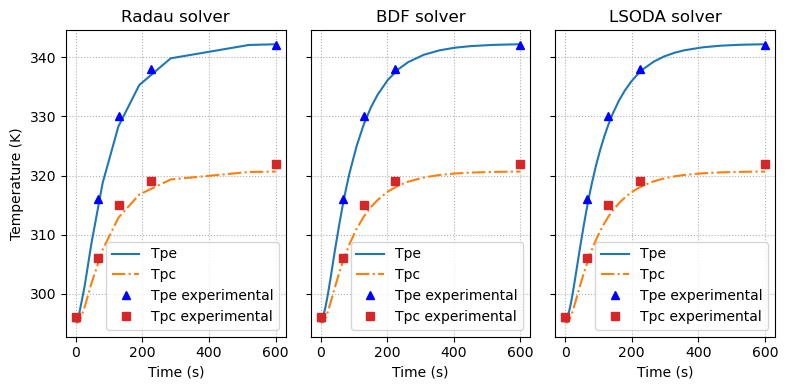

In [232]:
#Create a subplot with 2 figures
fig, axs = plt.subplots(1,3,sharey=True,figsize = [8,4])

axs[0].plot(t_rad,y_rad[0],label="Tpe")
axs[0].plot(t_rad,y_rad[1],label="Tpc", linestyle="-.")
#axs[0].plot(t_rad,y_rad[2],label="Twe")
#axs[0].plot(t_rad,y_rad[3],label="Twc")
#axs[0].plot(t_rad,y_rad[4],label="Tpa")
#axs[0].plot(t_rad,y_rad[5],label="Twa")
axs[0].plot(elgenk_times, elgenk_wallTempe, label="Tpe experimental",color = 'blue', linestyle ="None", marker ="^")
axs[0].plot(elgenk_times, elgenk_wallTempc, label="Tpc experimental",color = 'C3', linestyle ="None", marker ="s")

axs[0].grid(linestyle=":")
axs[0].set_title("Radau solver")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Temperature (K)")

axs[1].plot(t_bdf,y_bdf[0],label="Tpe")
axs[1].plot(t_bdf,y_bdf[1],label="Tpc", linestyle="-.")
#axs[1].plot(t_bdf,y_bdf[2],label="Twe")
#axs[1].plot(t_bdf,y_bdf[3],label="Twc")
#axs[1].plot(t_bdf,y_bdf[4],label="Tpa")
#axs[1].plot(t_bdf,y_bdf[5],label="Twa")
axs[1].plot(elgenk_times, elgenk_wallTempe, label="Tpe experimental",color = 'blue', linestyle ="None", marker ="^")
axs[1].plot(elgenk_times, elgenk_wallTempc, label="Tpc experimental",color = 'C3', linestyle ="None", marker ="s")


axs[1].grid(linestyle=":")
axs[1].set_title("BDF solver")
axs[1].set_xlabel("Time (s)")


axs[2].plot(t_lsoda,y_lsoda[0],label="Tpe")
axs[2].plot(t_lsoda,y_lsoda[1],label="Tpc", linestyle="-.")
#axs[2].plot(t_lsoda,y_lsoda[2],label="Twe")
#axs[2].plot(t_lsoda,y_lsoda[3],label="Twc")
#axs[2].plot(t_lsoda,y_lsoda[4],label="Tpa")
#axs[2].plot(t_lsoda,y_lsoda[5],label="Twa")
axs[2].plot(elgenk_times, elgenk_wallTempe, label="Tpe experimental", color = 'blue', linestyle ="None", marker ="^")
axs[2].plot(elgenk_times, elgenk_wallTempc, label="Tpc experimental",color = 'C3', linestyle ="None", marker ="s")


axs[2].grid(linestyle=":")
axs[2].set_title("LSODA solver")
axs[2].set_xlabel("Time (s)")



axs[0].legend(loc='lower right')
axs[1].legend(loc='lower right')
axs[2].legend(loc='lower right')

plt.tight_layout()

### Pressure plots

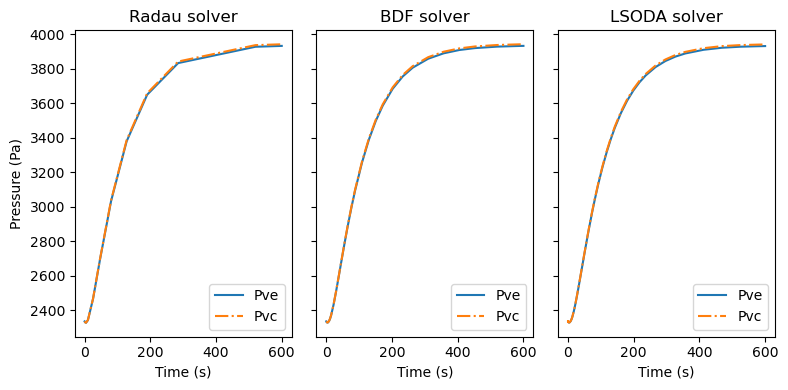

In [233]:
#Pressure plot
fig, axs = plt.subplots(1,3,sharey=True,figsize = [8,4])

axs[0].plot(t_rad,y_rad[7], label="Pve")
axs[0].plot(t_rad,y_rad[8], label="Pvc", linestyle="-.")
axs[0].set_title("Radau solver")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Pressure (Pa)")

axs[1].plot(t_bdf,y_bdf[7], label="Pve")
axs[1].plot(t_bdf,y_bdf[8], label="Pvc", linestyle="-.")
axs[1].set_title("BDF solver")
axs[1].set_xlabel("Time (s)")

axs[2].plot(t_lsoda,y_lsoda[7], label="Pve")
axs[2].plot(t_lsoda,y_lsoda[8], label="Pvc", linestyle="-.")
axs[2].set_title("LSODA solver")
axs[2].set_xlabel("Time (s)")

axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()

### Plot liquid mass in wick

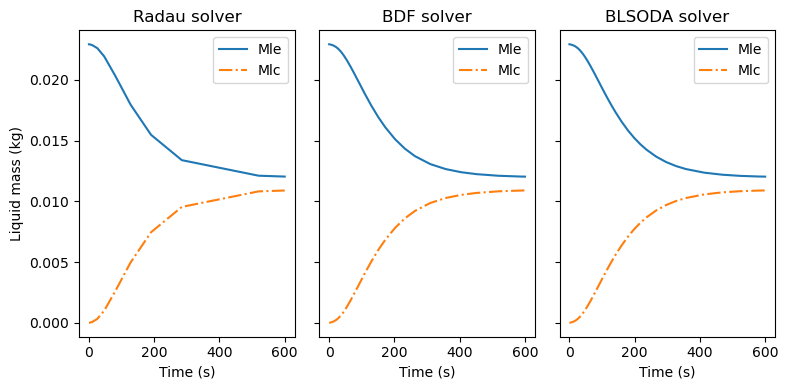

In [234]:
fig, axs = plt.subplots(1,3,sharey=True,figsize = [8,4])

axs[0].plot(t_rad,y_rad[11], label="Mle")
axs[0].plot(t_rad,y_rad[12], label="Mlc", linestyle="-.")
axs[0].set_title("Radau solver")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Liquid mass (kg)")

axs[1].plot(t_bdf,y_bdf[11], label="Mle")
axs[1].plot(t_bdf,y_bdf[12], label="Mlc", linestyle="-.")
axs[1].set_title("BDF solver")
axs[1].set_xlabel("Time (s)")

axs[2].plot(t_lsoda,y_lsoda[11], label="Mle")
axs[2].plot(t_lsoda,y_lsoda[12], label="Mlc", linestyle="-.")
axs[2].set_title("BLSODA solver")
axs[2].set_xlabel("Time (s)")

axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()


### Comparison considering the same amount of timesteps:

In [235]:
#TIME SPAN
tt = [0,2000]
#TIMESTEPS
Nsteps = 5000
tsteps = np.linspace(tt[0],tt[-1],Nsteps)

#SOLVE THE MODEL - Radau
st = time.time()
solution = solve_ivp(hp_model1,t_span = tt, t_eval  = tsteps, y0 = y0 ,method='Radau')
et = time.time()

print("simulation time Radau (s):", round(et-st,4))

#SAVE THE SOLUTION - Radau
t_rad = solution.t
y_rad = solution.y



#SOLVE THE MODEL - BDF
st = time.time()
solution = solve_ivp(hp_model1,t_span = tt, t_eval  = tsteps, y0 = y0 ,method='BDF')
et = time.time()

print("simulation time BDF (s):", round(et-st,4))

#SAVE THE SOLUTION - BDF
t_bdf = solution.t
y_bdf = solution.y


#SOLVE THE MODEL - LSODA

st = time.time()
solution = solve_ivp(hp_model1,t_span = tt, y0 = y0 ,method='LSODA')
et = time.time()

print("simulation time LSODA (s):", round(et-st,4))

#SAVE THE SOLUTION - LSODA
t_lsoda = solution.t
y_lsoda = solution.y

#Note: explicit RK method are not adopted since are pretty slow for this model, stiff problem

simulation time Radau (s): 0.0362
simulation time BDF (s): 0.0305
simulation time LSODA (s): 0.0554


The situation is still the same, BDF is faster

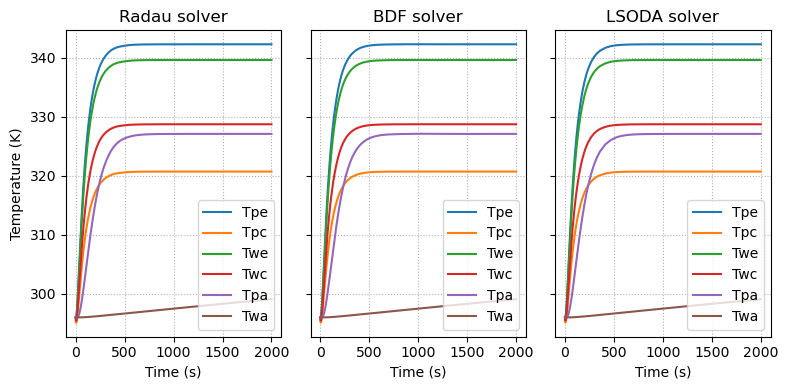

In [236]:
fig, axs = plt.subplots(1,3,sharey=True,figsize = [8,4])

axs[0].plot(t_rad,y_rad[0],label="Tpe")
axs[0].plot(t_rad,y_rad[1],label="Tpc")
axs[0].plot(t_rad,y_rad[2],label="Twe")
axs[0].plot(t_rad,y_rad[3],label="Twc")
axs[0].plot(t_rad,y_rad[4],label="Tpa")
axs[0].plot(t_rad,y_rad[5],label="Twa")
axs[0].grid(linestyle=":")
axs[0].set_title("Radau solver")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Temperature (K)")

axs[1].plot(t_bdf,y_bdf[0],label="Tpe")
axs[1].plot(t_bdf,y_bdf[1],label="Tpc")
axs[1].plot(t_bdf,y_bdf[2],label="Twe")
axs[1].plot(t_bdf,y_bdf[3],label="Twc")
axs[1].plot(t_bdf,y_bdf[4],label="Tpa")
axs[1].plot(t_bdf,y_bdf[5],label="Twa")
axs[1].grid(linestyle=":")
axs[1].set_title("BDF solver")
axs[1].set_xlabel("Time (s)")

axs[2].plot(t_lsoda,y_lsoda[0],label="Tpe")
axs[2].plot(t_lsoda,y_lsoda[1],label="Tpc")
axs[2].plot(t_lsoda,y_lsoda[2],label="Twe")
axs[2].plot(t_lsoda,y_lsoda[3],label="Twc")
axs[2].plot(t_lsoda,y_lsoda[4],label="Tpa")
axs[2].plot(t_lsoda,y_lsoda[5],label="Twa")



axs[2].grid(linestyle=":")
axs[2].set_title("LSODA solver")
axs[2].set_xlabel("Time (s)")



axs[0].legend(loc='lower right')
axs[1].legend(loc='lower right')
axs[2].legend(loc='lower right')
plt.tight_layout()


The three models do not give the exact same solution, in fact, if we analyze the adiabatic wall temperature we see that BDF and LSODA give as output some artifacts:

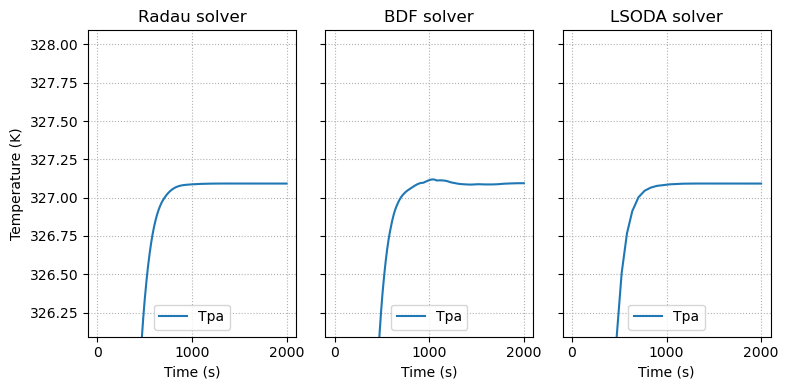

In [237]:
fig, axs = plt.subplots(1,3,sharey=True,figsize = [8,4])


axs[0].plot(t_rad,y_rad[4],label="Tpa")

axs[0].set_ylim([max(y_rad[4]) - 1, max(y_rad[4])+ 1])
axs[0].grid(linestyle=":")
axs[0].set_title("Radau solver")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Temperature (K)")

axs[1].plot(t_bdf,y_bdf[4],label="Tpa")

axs[1].grid(linestyle=":")
axs[1].set_title("BDF solver")
axs[1].set_xlabel("Time (s)")


axs[2].plot(t_lsoda,y_lsoda[4],label="Tpa")

axs[2].grid(linestyle=":")
axs[2].set_title("LSODA solver")
axs[2].set_xlabel("Time (s)")

axs[0].legend(loc='lower center')
axs[1].legend(loc='lower center')
axs[2].legend(loc='lower center')

plt.tight_layout()


BDF leads to a strange behavior in pipe temperature Tpa. There are no physical or mathematical reasons for such trend, in fact, the equation for pipe temperature in adiabatic region involves only smooth quantities, and thus the solution is expeted to be smooth as well. 
$$ 
C_{pa}\frac{dT_{pa}}{dt} = \frac{T_{pe} - T_{pa}}{R_{1pa}} -\frac{T_{pa} - T_{pc}}{R_{2pa}}
$$ 

To conclude, the three solvers behave very similarly both in computational time and results accuracy. It has been observed that using temperature dependent parameters, when it works without errors, the solvers provide different results.

### Temperature dependent parameters with BDF solver

In this final section i compare the performance and the results of BDF method in solving the "constant properties" model (hp_model1(t,y)) and the "temperature dependent properties" model (hp_modelTdependent(t,y)).

In [238]:
#TIME SPAN
tt = [0,2000]
#TIMESTEPS
Nsteps = 5000
tsteps = np.linspace(tt[0],tt[-1],Nsteps)

#SOLVE THE MODEL -  constant param
st = time.time()
solution = solve_ivp(hp_model1,t_span = tt, t_eval  = tsteps, y0 = y0 ,method='BDF')
et = time.time()

print("simulation time with constant parameters (s):", round(et-st,4))

#SAVE THE SOLUTION -  constant param
t_C = solution.t
y_C = solution.y



#SOLVE THE MODEL -  T dep param
st = time.time()
solution = solve_ivp(hp_modelTdependent,t_span = tt, t_eval  = tsteps, y0 = y0 ,method='BDF')
et = time.time()

print("simulation time with temperature dependent parameters (s):", round(et-st,4))

#SAVE THE SOLUTION -  T dep param
t_T = solution.t
y_T = solution.y




#Note: explicit RK method are not adopted since are pretty slow for this model, stiff problem

simulation time with constant parameters (s): 0.0344
simulation time with temperature dependent parameters (s): 0.2308


The model with temperature dependent parameters runs slower. 

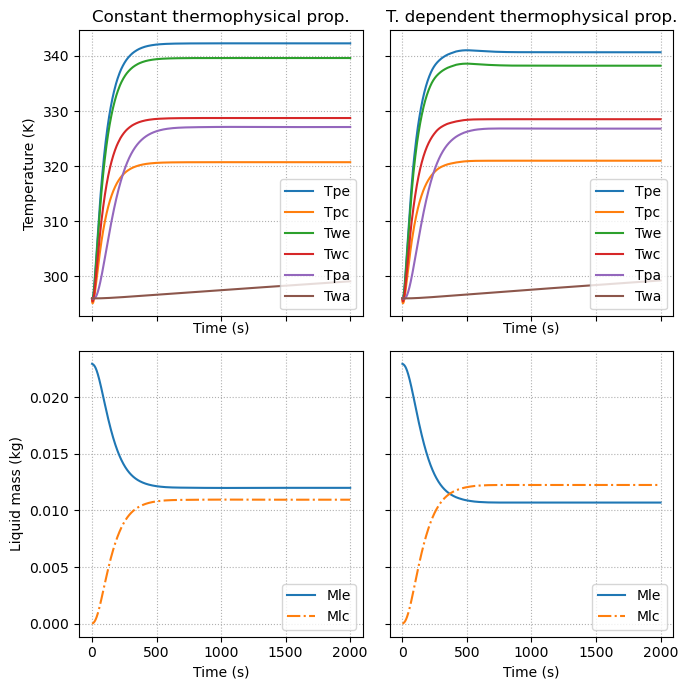

In [239]:
fig, axs = plt.subplots(2,2,sharey='row', sharex="col",figsize = [7,7])

axs[0,0].plot(t_C,y_C[0],label="Tpe")
axs[0,0].plot(t_C,y_C[1],label="Tpc")
axs[0,0].plot(t_C,y_C[2],label="Twe")
axs[0,0].plot(t_C,y_C[3],label="Twc")
axs[0,0].plot(t_C,y_C[4],label="Tpa")
axs[0,0].plot(t_C,y_C[5],label="Twa")
axs[0,0].grid(linestyle=":")
axs[0,0].set_title("Constant thermophysical prop.")
axs[0,0].set_xlabel("Time (s)")
axs[0,0].set_ylabel("Temperature (K)")

axs[0,1].plot(t_T,y_T[0],label="Tpe")
axs[0,1].plot(t_T,y_T[1],label="Tpc")
axs[0,1].plot(t_T,y_T[2],label="Twe")
axs[0,1].plot(t_T,y_T[3],label="Twc")
axs[0,1].plot(t_T,y_T[4],label="Tpa")
axs[0,1].plot(t_T,y_T[5],label="Twa")
axs[0,1].grid(linestyle=":")
axs[0,1].set_title("T. dependent thermophysical prop.")
axs[0,1].set_xlabel("Time (s)")

axs[0,0].legend(loc='lower right')
axs[0,1].legend(loc='lower right')


axs[1,0].plot(t_C,y_C[11], label="Mle")
axs[1,0].plot(t_C,y_C[12], label="Mlc", linestyle="-.")

axs[1,0].grid(linestyle=":")
axs[1,0].set_xlabel("Time (s)")
axs[1,0].set_ylabel("Liquid mass (kg)")

axs[1,1].plot(t_T,y_T[11], label="Mle")
axs[1,1].plot(t_T,y_T[12], label="Mlc", linestyle="-.")

axs[1,1].grid(linestyle=":")
axs[1,1].set_xlabel("Time (s)")


axs[1,0].legend(loc='lower right')
axs[1,1].legend(loc='lower right')

plt.tight_layout()

Temperature results are slightly different, what changes the most is the mass inside the wick.